# Simulating phenotypes

- Mock example with very small sample size and number of SNPs
- Simple example using 2 components (genetic and noise), and bi-allelic SNPs
- Frequencies to sample alleles: 0.1, 0.2, 0.3

# Functions

In [41]:
library(data.table)

# simulation of genotype
simGenotype = function(N = 50, nSNP = 30, frequencies = c(0.1, 0.2, 0.4)) {
    sps = paste0("%0", nchar(as.character(N)), "d")
    spsn = paste0("%0", nchar(as.character(nSNP)), "d")
    
    samples = paste0("ID_", sprintf(sps, 1:N))
    snps = paste0("SNP_", sprintf(spsn, 1:nSNP))
    freq = sample(frequencies, nSNP, replace = TRUE)
    X <- sapply(1:nSNP, function(x) rbinom(N, 2, freq[x]))
    colnames(X) <- snps
    rownames(X) <- samples
    return(X)
}

# creates genotype effects (from a normal distribution)
geneticEffects = function (genotype, causalSNP = 10, mBeta = 0, sdBeta = 1) {
    cSNP = sort(sample(colnames(genotype), causalSNP, replace = FALSE))
    betas = rnorm(causalSNP, mBeta, sdBeta)
    g = colnames(genotype)
    effects = rep(0, length(g))
    effects[g %in% cSNP] = betas
    names(effects) = g
    return(effects)
}

# create pairs of individuals based on given parameter of mating
createPairs = function(trait, random_mating = 0.5, groups = 10) {
    tt = trait[, .(id, trait)]
    tt[, g := cut(trait , quantile(trait, probs = (0:groups)/groups),
        labels = FALSE, include.lowest = TRUE)]

    pairs = NULL
    for (i in 1:nrow(tt)) {
        if (nrow(tt) >= 2) {
            if (runif(1) < random_mating) {
                cc = tt[sample(.N, 2)]$id
                tt = tt[!id %in% cc]
                pairs = rbind(pairs, as.vector(cc))}
            else {
                sid = tt[sample(.N, 1)]$id
                sg = tt[id == sid]$g
                tt = tt[!id %in% sid]
                aid = tt[g == sg][sample(.N, 1)]$id
                if (length(aid) == 0) { aid = tt[sample(.N, 1)]$id }
                tt = tt[!id %in% aid]
                pairs = rbind(pairs, c(sid, aid))
            }
        }
    }
    return(pairs)
}

# retrieve genotype info of couples
createCouples = function(genotype, trait, random_mating = 0.5) {
    temp = rownames(genotype)
    pairs = createPairs(trait, random_mating = random_mating)
    couples = list()
    snps = colnames(genotype)
    for (i in 1:nrow(pairs)) {
        temp = data.table(t(genotype[pairs[i,], ]))
        rownames(temp) = snps 
        couples[[i]] = temp
    }
    return(couples)
}

# creation of offspring
# very important are the mendelian rules below
reproduce = function(couples, nkids = 2) {

    # mendelian rules (very important)
    m = matrix(c(1, 0, 0, 0.5, 0.5, 0, 0, 1, 0, 0.25, 0.50, 0.25, 0, 0.50, 0.5, 0, 0, 1), 
        nrow = 6, ncol = 3, byrow  = TRUE)       
    colnames(m) = c(0, 1, 2)
    rownames(m) = c("00", "01", "02", "11", "12", "22")
    
    kids = list()
    
    family = data.table()
    j = 1

    for (i in seq_along(couples)) {
        for (ii in 1:nkids) {
            temp = couples[[i]]
            fids = colnames(temp)
            temp$k = temp[, apply(.SD, 1, getKidGenotype, matrix = m)]
            temp = temp[, .(k)]
            setnames(temp, "k", paste0("ID_", j))
            temp[, snp := rownames(couples[[1]])]
            kids[[paste0(i, ii)]] = temp

            family = rbind(family, data.table(father = fids[1], mother = fids[2], kid = paste0("ID_", j)))
            j = j+1
        }
    }

    kk = Reduce(function(...) merge(...,  by = "snp"), kids)
    kk[, snp := NULL]
    kk = as.matrix(t(kk))
    colnames(kk) = rownames(couples[[1]])
    return(list(kk, family))
}


# function to get offspring genotype using mendelian rules
getKidGenotype = function(values, matrix) {
    comba = paste0(values, collapse = "")
    combb = paste0(rev(values), collapse = "")
    s = grep(paste0(comba, "|", combb), rownames(matrix))
    prob = as.vector(matrix[s, ])
    return(sample(0:2, size = 1, prob = prob))
}


# define genetic trait component of kids (i.e., polygenic score)
simKidTrait = function(kids, ge) {
    return(kids[[1]] %*% ge)
}

# define noise component (from normal distribution)
getNoiseComponent = function(genotype, mNoise = 0, sdNoise = 1) {
    n = nrow(genotype)
    return(rnorm(n, mNoise, sdNoise))
}

# the functions below are important to define the relative importance of each component
# rescale variance of components
rescaleVar = function(component, prop) {
    component = as.vector(component) 
    var_component = var(component)
    scale_factor = sqrt(prop/var_component)
    return(component * scale_factor)
}

# scaling factor of components
scalingFactor = function(component, prop) {
    component = as.vector(component) 
    var_component = var(component)
    return(sqrt(prop/var_component))
}

# print variance composition
printVarianceComp = function(trait, component, name = "genetic part: ") {
    v = round((var(component) / var(trait))[1, 1], 3)
    print(paste0(name, v))
}

# Initial example to explore output
- 3000 people
- 300 snps
- 50 causal

In [35]:
gen = 0.3
noise = 1 - gen
genotype = simGenotype(3000, 300)
ge = geneticEffects(genotype, 50, sdBeta = 0.175)


In [45]:
# adjusting scale based on number of SNP and SDs of effects
parentGComp = (genotype %*% ge)
parentNComp = getNoiseComponent(genotype)
parentTrait = parentGComp + parentNComp 
dparentTrait = data.table(id = rownames(parentTrait), trait = parentTrait[, 1])

# using scaling factor
# pgsf = scalingFactor(parentGComp, gen)
# pnsf = scalingFactor(parentNComp, noise)
# parentTrait =parentGComp * pgsf  + parentNComp * pnsf


In [46]:
printVarianceComp(parentTrait, parentGComp)
printVarianceComp(parentTrait, parentNComp, name = "noise part: ")

[1] "genetic part: 0.349"
[1] "noise part: 0.625"


In [47]:
# explore simulated genotype
head(genotype)

,SNP_001,SNP_002,SNP_003,SNP_004,SNP_005,SNP_006,SNP_007,SNP_008,SNP_009,SNP_010,⋯,SNP_291,SNP_292,SNP_293,SNP_294,SNP_295,SNP_296,SNP_297,SNP_298,SNP_299,SNP_300
ID_0001,0,0,1,1,0,1,0,0,0,1,⋯,1,0,2,0,0,1,0,1,1,2
ID_0002,0,1,1,1,0,1,0,1,0,0,⋯,2,2,1,0,1,1,0,0,0,0
ID_0003,0,0,2,2,0,0,1,0,0,1,⋯,2,1,0,0,2,0,1,0,0,0
ID_0004,1,0,0,1,1,0,0,1,0,0,⋯,1,1,0,0,1,0,0,1,0,1
ID_0005,0,1,0,2,0,1,0,0,1,0,⋯,2,1,0,0,1,0,0,0,1,1
ID_0006,0,0,0,1,0,1,0,1,0,0,⋯,1,2,0,0,1,0,1,1,0,2


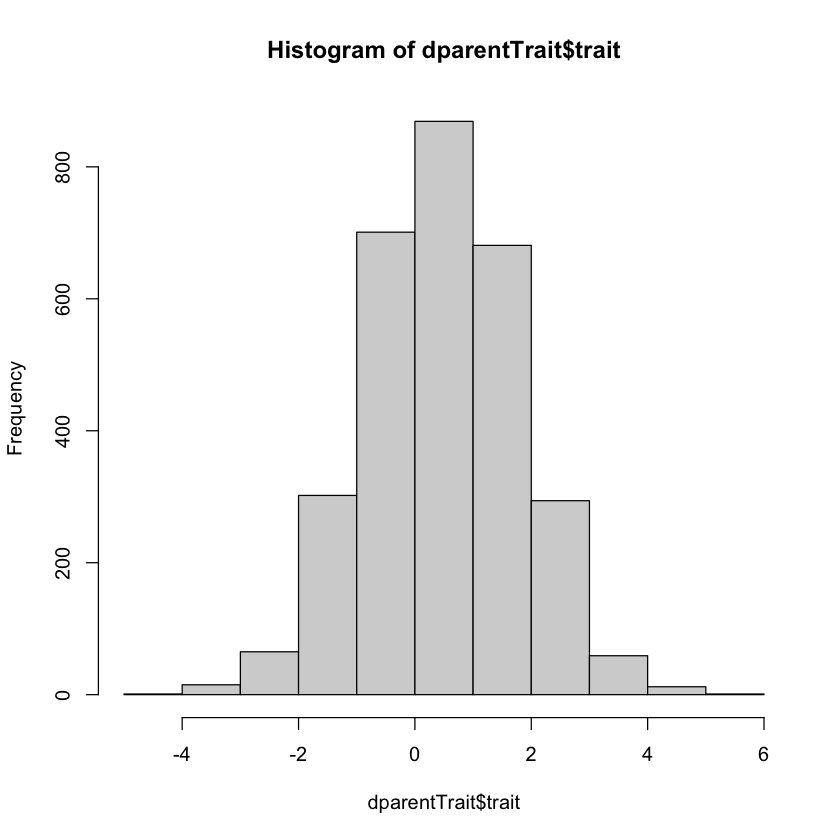

In [51]:
# distribution of trait
hist(dparentTrait$trait)

# Several generations

In [57]:
# function to create several generations
# very inefficient function
createGenerations = function(nGen = 3, N = 1000, nSNP = 100, causalSNP = 50, genVar = 0.3, 
    genotype = NULL, effects = NULL, random_mating = 1) {
    noise = 1 - genVar
    if (is.null(genotype)) { genotype = simGenotype(N, nSNP) }
    if (is.null(effects)) { effects = geneticEffects(genotype, causalSNP, sdBeta = 0.175) }
    #print(table(ge[ge != 0] > 0))
    traits = list()

    parentGComp = genotype %*% effects
    parentNComp = getNoiseComponent(genotype)

    #pgsf = scalingFactor(parentGComp, gen)
    #pnsf = scalingFactor(parentNComp, noise)
    # parentTrait = parentGComp * pgsf + parentNComp * pnsf
    parentTrait = parentGComp + parentNComp 
    dparentTrait = data.table(id = rownames(parentTrait), trait = parentTrait[, 1], pgs = parentGComp[,1])
    kids = NULL
    for (i in 1:nGen) {
        print(paste0("::::::: creating generation: ", i))
        if (i == 1) {
            couples = createCouples(genotype, dparentTrait, random_mating = random_mating)
            kids = reproduce(couples)
            # genetic part
            kidGComp = kids[[1]] %*%  effects
            # noise part
            kidNComp = getNoiseComponent(kids[[1]])
            # trait
            # kidTrait = kidGComp * pgsf + kidNComp * pnsf
            kidTrait = kidGComp + kidNComp
            dkidTrait = data.table(id = rownames(kidTrait), trait = kidTrait[, 1], pgs = kidGComp[, 1])
            # merge traits
            family = kids[[2]]
            dkidTrait = merge(dkidTrait, family, by.x = "id", by.y = "kid")
            dkidTrait = merge(dkidTrait, dparentTrait[, .(id, father_trait = trait, father_pgs = pgs)], 
                by.x = "father", by.y = "id", all.x = TRUE)
            dkidTrait = merge(dkidTrait, dparentTrait[, .(id, mother_trait = trait, mother_pgs = pgs)], 
                by.x = "mother", by.y = "id", all.x = TRUE)
            traits[[i]] = dkidTrait
        } else {
            couples = createCouples(kids[[1]], dkidTrait, random_mating = random_mating)
            kids = reproduce(couples)
            dparentTrait = dkidTrait
            # genetic part
            kidGComp = kids[[1]] %*%  effects
            # noise part
            kidNComp = getNoiseComponent(kids[[1]])
            # trait
            #kidTrait = kidGComp * pgsf + kidNComp * pnsf
            kidTrait = kidGComp + kidNComp
            dkidTrait = data.table(id = rownames(kidTrait), trait = kidTrait[, 1], pgs = kidGComp[, 1])
            # merge traits
            family = kids[[2]]
            dkidTrait = merge(dkidTrait, family, by.x = "id", by.y = "kid")
            dkidTrait = merge(dkidTrait, dparentTrait[, .(id, father_trait = trait, father_pgs = pgs)],
                by.x = "father", by.y = "id", all.x = TRUE)
            dkidTrait = merge(dkidTrait, dparentTrait[, .(id, mother_trait = trait, mother_pgs = pgs)], 
                by.x = "mother", by.y = "id", all.x = TRUE)
            traits[[i]] = dkidTrait
        }   
    }
    return(rbindlist(traits, idcol = "generation"))
}

# Example with some assortative mating
- 30 generations

In [74]:
# simulate baseline phenotype
genotype = simGenotype(1000, 200)
ge = geneticEffects(genotype, 50, sdBeta = 0.175)
# prop of positive and negative effects
prop.table(table(ge[ge != 0] > 0))


FALSE  TRUE 
 0.38  0.62 

In [75]:
tt = createGenerations(nGen = 30, genotype = genotype, effects = ge, random_mating = 0.80)

[1] "::::::: creating generation: 1"
[1] "::::::: creating generation: 2"
[1] "::::::: creating generation: 3"
[1] "::::::: creating generation: 4"
[1] "::::::: creating generation: 5"
[1] "::::::: creating generation: 6"
[1] "::::::: creating generation: 7"
[1] "::::::: creating generation: 8"
[1] "::::::: creating generation: 9"
[1] "::::::: creating generation: 10"
[1] "::::::: creating generation: 11"
[1] "::::::: creating generation: 12"
[1] "::::::: creating generation: 13"
[1] "::::::: creating generation: 14"
[1] "::::::: creating generation: 15"
[1] "::::::: creating generation: 16"
[1] "::::::: creating generation: 17"
[1] "::::::: creating generation: 18"
[1] "::::::: creating generation: 19"
[1] "::::::: creating generation: 20"
[1] "::::::: creating generation: 21"
[1] "::::::: creating generation: 22"
[1] "::::::: creating generation: 23"
[1] "::::::: creating generation: 24"
[1] "::::::: creating generation: 25"
[1] "::::::: creating generation: 26"
[1] "::::::: creating

In [76]:
dtt = tt[, .(average = mean(trait), 
    sd = sd(trait),
    cor_trait_kid_father = cor(trait, father_trait), 
    cor_trait_kid_mother = cor(trait, mother_trait), 
    cor_trait_father_mother = cor(father_trait, mother_trait), 
    cor_pgs_kid_father = cor(pgs, father_pgs), 
    cor_pgs_kid_mother = cor(pgs, mother_pgs), 
    cor_pgs_father_mother = cor(father_pgs, mother_pgs), 
    prop_g_variance = var(pgs)/var(trait)), generation]
dtt

generation,average,sd,cor_trait_kid_father,cor_trait_kid_mother,cor_trait_father_mother,cor_pgs_kid_father,cor_pgs_kid_mother,cor_pgs_father_mother,prop_g_variance
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7279017,1.219650,0.1302808,0.1828825,0.1527777,0.5077606,0.4949551,0.03073446,0.2943962
2,0.7194000,1.152950,0.1542492,0.1770647,0.2321515,0.4796766,0.5149381,-0.01124527,0.3323183
3,0.8057838,1.229955,0.2085499,0.1074632,0.1706523,0.5212702,0.5262213,0.02829453,0.2922165
4,0.7872658,1.251712,0.1514015,0.1433219,0.2071750,0.5416235,0.4932840,0.04241787,0.3087249
5,0.7962059,1.198803,0.1756995,0.1840315,0.1009415,0.5859958,0.4876370,0.06983055,0.3537289
6,0.7468637,1.218732,0.2022921,0.1818693,0.1513631,0.5827989,0.5170066,0.10482317,0.3451975
7,0.7758298,1.193892,0.1847560,0.1461477,0.1268827,0.4534951,0.5022920,-0.07169972,0.3040717
8,0.7192052,1.239011,0.2022658,0.1675929,0.2179741,0.5085525,0.5358266,0.06243207,0.2978097
9,0.7553312,1.196888,0.1761191,0.1834950,0.2600196,0.5341610,0.5575495,0.09114359,0.3271908


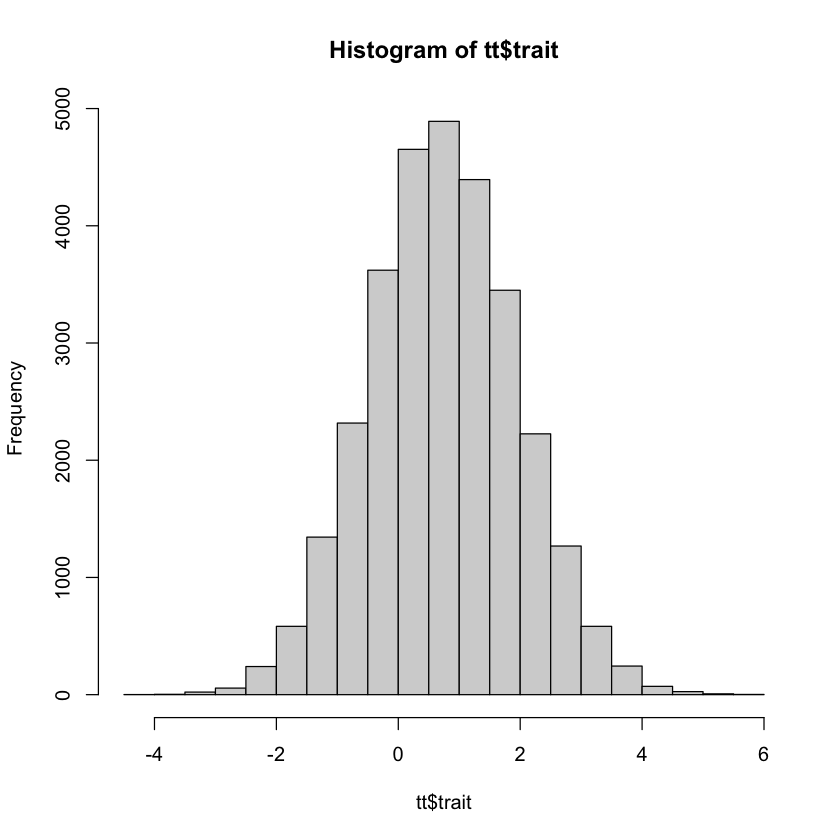

In [84]:
hist(tt$trait)

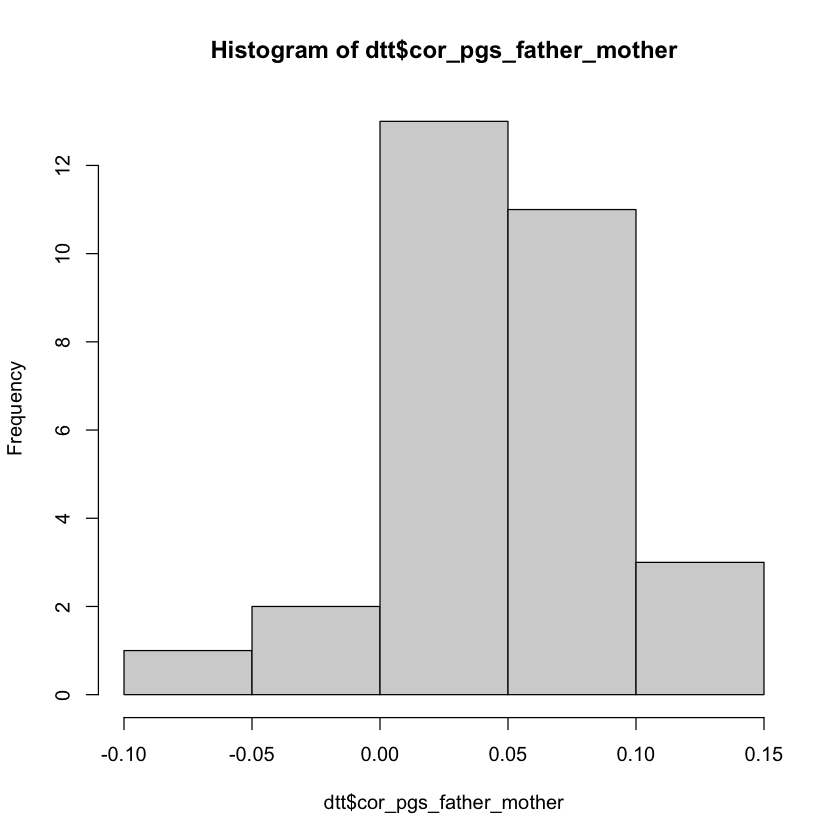

In [83]:
hist(dtt$cor_pgs_father_mother)

In [103]:
# some correlation between pgs
mean(dtt$cor_pgs_father_mother)


[1] 0.04877186

# Example with random mating

- 30 generations

In [79]:
cc = createGenerations(nGen = 30, genotype = genotype, effects = ge, random_mating = 1.0)

[1] "::::::: creating generation: 1"
[1] "::::::: creating generation: 2"
[1] "::::::: creating generation: 3"
[1] "::::::: creating generation: 4"
[1] "::::::: creating generation: 5"
[1] "::::::: creating generation: 6"
[1] "::::::: creating generation: 7"
[1] "::::::: creating generation: 8"
[1] "::::::: creating generation: 9"
[1] "::::::: creating generation: 10"
[1] "::::::: creating generation: 11"
[1] "::::::: creating generation: 12"
[1] "::::::: creating generation: 13"
[1] "::::::: creating generation: 14"
[1] "::::::: creating generation: 15"
[1] "::::::: creating generation: 16"
[1] "::::::: creating generation: 17"
[1] "::::::: creating generation: 18"
[1] "::::::: creating generation: 19"
[1] "::::::: creating generation: 20"
[1] "::::::: creating generation: 21"
[1] "::::::: creating generation: 22"
[1] "::::::: creating generation: 23"
[1] "::::::: creating generation: 24"
[1] "::::::: creating generation: 25"
[1] "::::::: creating generation: 26"
[1] "::::::: creating

In [80]:
dcc = cc[, .(average = mean(trait), 
    sd = sd(trait),
    cor_trait_kid_father = cor(trait, father_trait), 
    cor_trait_kid_mother = cor(trait, mother_trait), 
    cor_trait_father_mother = cor(father_trait, mother_trait), 
    cor_pgs_kid_father = cor(pgs, father_pgs), 
    cor_pgs_kid_mother = cor(pgs, mother_pgs), 
    cor_pgs_father_mother = cor(father_pgs, mother_pgs), 
    prop_g_variance = var(pgs)/var(trait)), generation]
dcc

generation,average,sd,cor_trait_kid_father,cor_trait_kid_mother,cor_trait_father_mother,cor_pgs_kid_father,cor_pgs_kid_mother,cor_pgs_father_mother,prop_g_variance
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7265399,1.222524,0.1810828,0.20735895,0.0846563125,0.5565446,0.5028677,0.074321782,0.3219048
2,0.7056000,1.166513,0.1583254,0.15145479,-0.0265915143,0.4962474,0.4969454,-0.043406733,0.3456710
3,0.8154381,1.210762,0.1289889,0.14341769,-0.0276820419,0.5143565,0.4903756,-0.009140583,0.3039216
4,0.8032584,1.190852,0.1398809,0.15828013,0.0054656837,0.5199766,0.5229609,0.047809405,0.3126954
5,0.7805763,1.162673,0.1617624,0.17924744,0.0205399872,0.5234006,0.5043584,0.024471839,0.3397261
6,0.7903225,1.195853,0.1646755,0.19602171,0.0969779650,0.5272148,0.5120674,0.050976934,0.3093639
7,0.7717517,1.244978,0.1730295,0.14969111,-0.0045373020,0.5288831,0.4783862,0.025377483,0.2926471
8,0.8687864,1.209714,0.1554796,0.08951892,-0.0591260584,0.4612626,0.4815106,-0.072923585,0.3019120
9,0.8472069,1.166985,0.1499318,0.12155286,0.0166475824,0.5134243,0.4937315,0.048095284,0.3248562


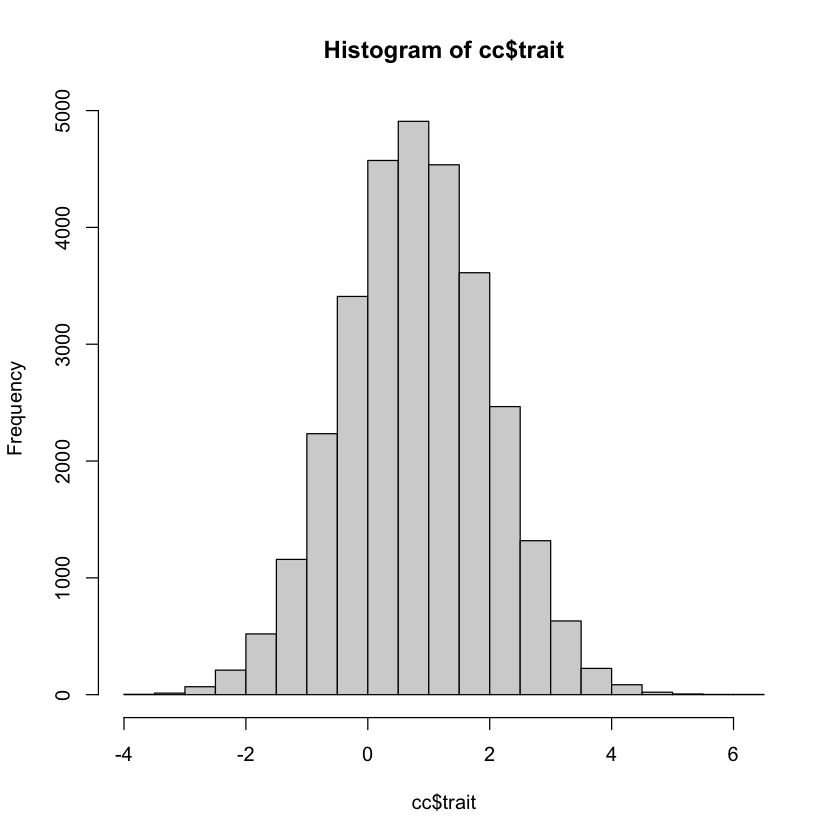

In [85]:
hist(cc$trait)

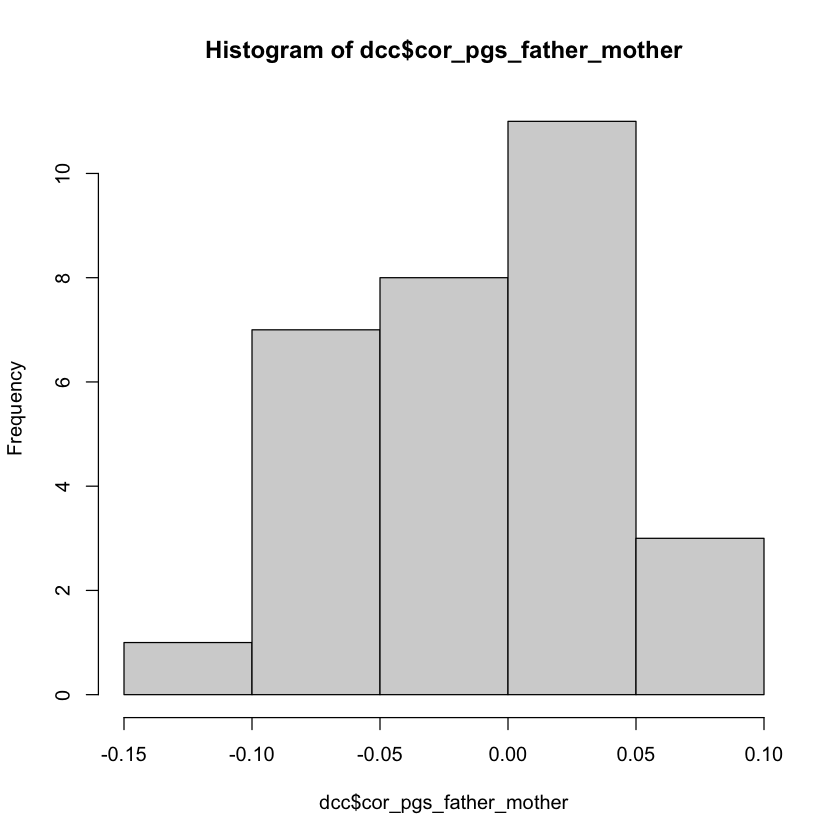

In [86]:
hist(dcc$cor_pgs_father_mother)

In [92]:
mean(dcc$cor_pgs_father_mother)

[1] -0.008351288

# Descriptive differences between scenarios

In [102]:
# no big differences in trait SD
sd(tt[generation == 30, trait])
sd(cc[generation == 30, trait])


[1] 1.168435

[1] 1.176283

In [100]:
# standard deviation of pgs: slighly smaller when there is assortative mating (expected)
sd(tt[generation == 30, pgs])
sd(cc[generation == 30, pgs])

[1] 0.6512954

[1] 0.6711894

In [101]:
# average trait: smaller when there is assortative mating (it depends on the distribution of effects)
mean(tt[generation == 30, trait])
mean(cc[generation == 30, trait])


[1] 0.7725168

[1] 0.8368777